<a href="https://colab.research.google.com/github/RaduW/volume-rebalance/blob/main/volume_rebalancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Volume Rebalancing Algorithm


The volume rebalancing algorithm is based on the assumption that while given a global sample rate classes we want to adjust the individual class sampling rate in a way that equalises the number of sampled elements in each class while maintaining the overall sample rate.

In [13]:
# url = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/transaction_adjustment_model.py"
# !wget --no-cache --backups=1 {url}
#
from transaction_adjustment_model import adjust_sample_rate_v2
#
# utils_url = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/utils.py"
# !wget --no-cache --backups=1 {utils_url}

import utils

In [14]:

from typing import Tuple, Union
from ipywidgets import widgets
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [15]:
# import transaction data
projects = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/projects-2023-03-30.json"
trans_data = pd.read_json(projects)

PROJECTS = {
    "sentry": 1,
    "javascript": 11276,
    "snuba": 300688,
    "gibpotato-backend": 4504044639748096,
    #"gibpotato-frontend": 4504044640927744,
}

# sort by project and frequency and re-index
trans_data.sort_values(by=["proj_id","freq"],ignore_index=True, ascending=True, inplace=True)
trans_data = trans_data.reset_index(drop=True)
trans_data.head()

,name,freq,proj_id,proj_name
0,/api/0/customers/,1,1,sentry
1,/organizations/:orgId/alerts/rules/details/:ru...,1,1,sentry
2,/api/0/organizations/{organization_slug}/auth-...,1,1,sentry
3,//index.php,1,1,sentry
4,/api/0/users/{user_id}/,1,1,sentry


In [16]:
rules_file_name = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/rules-2023-03-30.json"
rules_data = utils.json_rules_to_frame(rules_file_name)
rules_data.head()

,factor,name
0,1.362553,/auth/login/{organization_slug}/
1,1.343255,sentry.tasks.files.delete_file
2,1.233424,sentry.tasks.check_auth_identity
3,1.029705,/dashboard/:dashboardId/
4,0.976686,sentry.profiles.task.process_profile


# Model params

The model has the following input parameters:

*   a list of initial counts representing the number of elements for each class `counts`
*   an overall desired sample rate: `global_rate` (input via slider)



In [17]:
def process_data(global_rate:float, items_high:int, items_low:int, project:str, trans_data: pd.DataFrame, intensity:float):

    data = trans_data.sort_values(by=["freq"],ignore_index=True, ascending=True)
    data = data[data["proj_name"] == project]

    counts = data["freq"]
    ideal_rate = counts.mean() * global_rate
    cnts_min = counts.min()
    cnts_max = counts.max()
    total = counts.sum()
    num_classes = len(counts)

    data = data.set_index("name", drop=False)
    data["original"] = data["freq"]* global_rate
    if items_low + items_high < num_classes:
      if items_high == 0:
        explicit_transactions = data[:items_low]
      else:
        explicit_transactions = pd.concat([data[:items_low], data[-items_high:]])
    else:
      explicit_transactions = data # we resize everything explicitly

    explicit_transactions_tuple = list(explicit_transactions[["name", "freq"]].itertuples(name=None, index=False))
    adjusted, implicit_rate = adjust_sample_rate_v2(classes=explicit_transactions_tuple, rate=global_rate, total_num_classes=num_classes, total=total, intensity=intensity)
    adjusted_df = pd.DataFrame.from_dict(data = adjusted, orient="index", columns=["adjusted_rate"] )

    # now calculate the adjusted count
    df = data.join(adjusted_df, how="outer")

    # # keep count of the explicit rates
    df["explicit"]= ~df['adjusted_rate'].isna()
    # # set the adjusted rates for the implicit values 
    df["adjusted_rate"] = df["adjusted_rate"].fillna(implicit_rate)

    df["adjusted"] = df["freq"]* df["adjusted_rate"]

    print( f"Num classes:{num_classes} implicit_rate:{implicit_rate} original_rate:{global_rate}")
    return df  



def plot_rates(ax, data, last_low, first_high, global_rate, x_limit=None, log=False):
  if x_limit is not None:
    ax.set_xlim(*x_limit)
    data = data[data["freq"]<x_limit[1]]

  if log:
    plt.xscale("log")
    plt.yscale("log")
  else:
    plt.xscale("linear")
    plt.yscale("linear")


  counts_series = data["freq"]

  cnts_min = counts_series.min()
  cnts_max =  counts_series.max()
  ideal_rate = counts_series.mean() * global_rate
  rate_max = data.rate.max()

  if not log:
    #ideal level
    ax.text((cnts_min+cnts_max)/2, ideal_rate, "ideal rate", horizontalalignment='center', verticalalignment="bottom", size='medium', color='black')
    sns.lineplot( x=[cnts_min, cnts_max], y=[ideal_rate,ideal_rate], ax = ax);
    # border lower values
    sns.lineplot( x=[last_low,last_low+0.001], y=[0, rate_max], color="blue", ax=ax);
    # border higher values
    sns.lineplot( x=[first_high,first_high+0.001], y=[0, rate_max], color="red", ax=ax, );

  sns.scatterplot(data=data, x="freq", y="rate", hue ="series", style="explicit", ax=ax)

def draw_rate_change(ax, df):
  def minor_tick_format(tick_val, tick_pos):
    if tick_val < 0:
      tick_val *= -1
    while tick_val < 1:
      tick_val *=10
    while tick_val > 10:
      tick_val /=10
    return f"{int(tick_val)%10}"
    

  ax.set_yscale("log")
  ax.set_xscale("log")
  ax.grid(which='minor')
  sns.scatterplot(data=df, x="freq", y="adjusted_rate", hue ="explicit", style="explicit", ax=ax)
  ax.xaxis.set_minor_formatter(minor_tick_format)
  ax.set_title("Sample Rate")


def draw_rebalance_graphs(global_rate, items_high, items_low, project, trans_data, intensity):

    df = process_data(global_rate, items_high, items_low, project, trans_data, intensity)

    counts_series = df["freq"]

    last_low = counts_series.iloc[items_low]
    first_high = counts_series.iloc[-items_high]

    df2 = df.melt(id_vars=["freq","explicit"],value_vars=["adjusted","original"], var_name="series", value_name = "rate")
    fig, ax = plt.subplots(nrows = 4 ,figsize=(20,20))
    
    draw_rate_change(ax[0], df)
    plot_rates(ax[1], df2, last_low, first_high, global_rate)
    plot_rates(ax[2], df2, last_low, first_high, global_rate, x_limit=(-20, 220))
    plot_rates(ax[3], df2, last_low, first_high, global_rate, log=True)





### Counts

In [18]:
trans_data.head()

,name,freq,proj_id,proj_name
0,/api/0/customers/,1,1,sentry
1,/organizations/:orgId/alerts/rules/details/:ru...,1,1,sentry
2,/api/0/organizations/{organization_slug}/auth-...,1,1,sentry
3,//index.php,1,1,sentry
4,/api/0/users/{user_id}/,1,1,sentry


### Sample rate

In [19]:
global_rate=widgets.FloatSlider(min=0,max=1,value=0.1, step=0.001 , description= "sample rate");
num_classes = len(trans_data)
items_high=widgets.BoundedIntText(min=0,max=num_classes,value=20,
                                  description="items high");
items_low =widgets.BoundedIntText(min=0,max=num_classes,value=20,step=1,
    description='items low')

project_names = list(PROJECTS.keys())

project= widgets.Dropdown(
    options=project_names,
    value='sentry',
    description='Project:',
)
#global_rate = widgets.FloatText(min=0,max=1,value=0.1, step=0.001 )
def rebalance_generator(trans_data):
  def inner( global_rate, items_high, items_low, project):
    draw_rebalance_graphs(global_rate, items_high,items_low, project, trans_data, 1)
  return inner

widgets.interact(rebalance_generator(trans_data), global_rate = global_rate, items_high=items_high, items_low=items_low, project=project);

interactive(children=(FloatSlider(value=0.1, description='sample rate', max=1.0, step=0.001), BoundedIntText(v…

## Implicit rate calculations

Show how the implicit rate changes with the amount of transactions considered
Both High and Low


In [20]:
rate =0.009313539800358329
project_name = "sentry"
proj_data = trans_data[trans_data["proj_name"] == project_name]
proj_data = proj_data.sort_values(by=["freq"],ignore_index=True, ascending=True)


def get_implicit_rate(global_rate:float, items_high:int, items_low:int, data: pd.DataFrame):
    counts = data["freq"]
    total = counts.sum()
    num_classes = len(counts)

    data = data.set_index("name", drop=False)
    if items_low + items_high < num_classes:
      if items_high == 0:
        explicit_transactions = data[:items_low]
      else:
        explicit_transactions = pd.concat([data[:items_low], data[-items_high:]])
    else:
      explicit_transactions = data # we resize everything explicitly

    explicit_transactions_tuple = list(explicit_transactions[["name", "freq"]].itertuples(name=None, index=False))
    adjusted, implicit_rate = adjust_sample_rate_v2(classes=explicit_transactions_tuple, rate=global_rate, total_num_classes=num_classes, total=total, intensity=1)
    return implicit_rate

def get_implicit_rates(rate, project_data):

  num_transactions = len(proj_data)
  rates = []
  for i in range(1,num_transactions):
    high = get_implicit_rate(rate, i, 0, proj_data)
    rates.append(("high",high, i))
    low = get_implicit_rate(rate, 0, i , proj_data)
    rates.append(("low",low, i))
    if i %2 == 0 :
      both = get_implicit_rate(rate, i//2, i//2, proj_data)
      rates.append(("both", both, i))
  
  df = pd.DataFrame(data=rates, columns=["adjust", "rate", "count"])
  df["factor"] = df["rate"]/rate
  return df

rates = get_implicit_rates(rate, proj_data)  



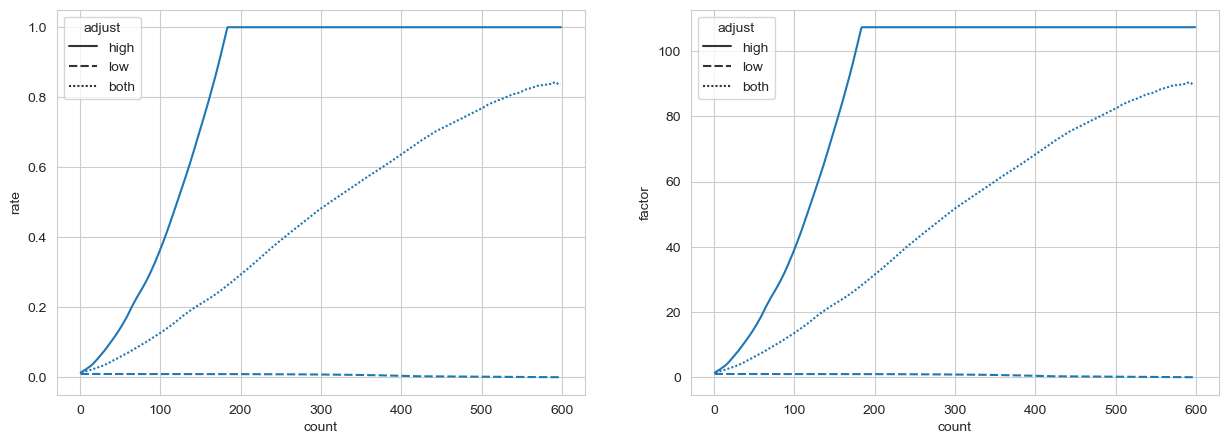

In [21]:
fig, ax =plt.subplots(1,2,figsize=(15, 5))
sns.lineplot(rates, x="count", y="rate", style="adjust", ax=ax[0])
sns.lineplot(rates, x="count", y="factor", style="adjust", ax=ax[1]);

In [22]:
r = rates.set_index("count").pivot(columns="adjust", values=["factor"])
r.columns   =list(map("_".join, r.columns))
r

,factor_both,factor_high,factor_low
count,,,
1,NaN,1.354277,0.999929
2,1.352017,1.606868,0.999859
3,NaN,1.768125,0.999788
4,1.601497,1.891286,0.999718
5,NaN,2.031437,0.999647
...,...,...,...
595,NaN,107.370562,0.016281
596,89.712440,107.370562,0.014041
597,NaN,107.370562,0.011435


In [23]:

f = rates.set_index("count").pivot(columns="adjust", values=["rate"])
f.columns   =list(map("_".join, f.columns))
f

,rate_both,rate_high,rate_low
count,,,
1,NaN,0.012613,0.009313
2,0.012592,0.014966,0.009312
3,NaN,0.016467,0.009312
4,0.014916,0.017615,0.009311
5,NaN,0.018920,0.009310
...,...,...,...
595,NaN,1.000000,0.000152
596,0.835540,1.000000,0.000131
597,NaN,1.000000,0.000106


In [28]:
items_high = 10
items_low = 20
rate = 0.1
intensity= 1.0

data = process_data(rate, items_high, items_low, "sentry", trans_data, intensity)
implicit_factor= rules_data.loc[ rules_data["name"]=="*"].iloc[0]["factor"]
rules_series = rules_data.set_index("name", drop=True)["factor"]

full_data = data.join(rules_series, how="left")
full_data["factor"] = full_data["factor"].fillna(implicit_factor)
full_data


Num classes:600 implicit_rate:0.27972316050849144 original_rate:0.1


,name,freq,proj_id,proj_name,original,adjusted_rate,explicit,adjusted,factor
,,2897,1,sentry,289.7,0.279723,False,810.357996,30.609375
/,/,2737,1,sentry,273.7,0.279723,False,765.602290,30.609375
/*,/*,300,1,sentry,30.0,0.279723,False,83.916948,30.609375
/.*/,/.*/,597,1,sentry,59.7,0.279723,False,166.994727,30.609375
/.well-known/dnt-policy.txt,/.well-known/dnt-policy.txt,115,1,sentry,11.5,0.279723,False,32.168163,30.609375
...,...,...,...,...,...,...,...,...,...
sentry.tasks.store.symbolicate_event,sentry.tasks.store.symbolicate_event,3777,1,sentry,377.7,0.279723,False,1056.514377,30.609375
sentry.tasks.store.symbolicate_event_low_priority,sentry.tasks.store.symbolicate_event_low_priority,1,1,sentry,0.1,0.279723,False,0.279723,30.609375
sentry.tasks.update_code_owners_schema,sentry.tasks.update_code_owners_schema,31,1,sentry,3.1,0.279723,False,8.671418,30.609375
sentry.tasks.user_report,sentry.tasks.user_report,1,1,sentry,0.1,0.279723,False,0.279723,30.609375


# Scratch pad below

Ignore....
